In [3]:
import numpy as np  
from rdflib import Graph, URIRef
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from node2vec import Node2Vec
from sklearn.manifold import TSNE



In [4]:

# Specify your TTL files
ttl_files = {
    "sample": "Master-EDA/sickbins-sample.ttl",  # Use this first for quick tests
    "full": "Master-EDA/sickbins.ttl",            # Main dataset
    "taxonomy": "Master-EDA/sickbins-taxonomy.ttl", # Taxonomy relationships
    "alignment": "Master-EDA/alignment.ttl"
}

# Function to load a TTL file
def load_graph(ttl_path):
    g = Graph()
    g.parse(ttl_path, format="turtle")
    print(f" Loaded {ttl_path}: {len(g)} triples found.")
    return g


In [5]:

# Load sample dataset first
graph_sample = load_graph(ttl_files["sample"])
# Load the taxonomy TTL file using your function
g_taxonomy = load_graph(ttl_files["taxonomy"])
# Load the alignment TTL file
g_alignment = load_graph(ttl_files["alignment"])



 Loaded Master-EDA/sickbins-sample.ttl: 440 triples found.
 Loaded Master-EDA/sickbins-taxonomy.ttl: 176 triples found.
 Loaded Master-EDA/alignment.ttl: 103 triples found.


In [6]:


# Convert RDF graph to NetworkX graph
nx_graph = nx.DiGraph()

for s, p, o in graph_sample:
    nx_graph.add_edge(str(s), str(o), label=str(p))

print(f" Converted RDF graph to NetworkX: {nx_graph.number_of_nodes()} nodes, {nx_graph.number_of_edges()} edges.")


 Converted RDF graph to NetworkX: 203 nodes, 440 edges.


In [7]:

# Step 1: Run node2vec on your NetworkX graph
node2vec = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

print(" node2vec embedding completed.")


Computing transition probabilities:   0%|          | 0/203 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 5238.30it/s]


 node2vec embedding completed.


In [ ]:

# Step 2: Prepare embeddings for t-SNE
labels = model.wv.index_to_key
vectors = np.array([model.wv[node] for node in labels])  



In [9]:

# Step 3: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000)
embeddings_2d = tsne.fit_transform(vectors)

print(" t-SNE dimensionality reduction completed.")


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


 t-SNE dimensionality reduction completed.


In [10]:
from rdflib.namespace import RDF

# Step: Build node type mapping from RDF graph
node_types = {}

for subj, pred, obj in graph_sample:
    if pred == RDF.type:
        node_types[str(subj)] = str(obj).split('/')[-1]  # Clean up to get class name

print(f" Extracted types for {len(node_types)} nodes.")

# Step: Prepare colors based on node types
color_map = {
    'TargetObject': 'red',
    'Observation': 'blue',
    'Reading': 'green',
    'Image': 'purple',
    'PointCloud': 'orange',
    'Conveyor': 'cyan',
    'owl#Ontology': 'black',
    'owl#NamedIndividual': 'brown',
}


colors = []
for label in labels:
    node_type = node_types.get(label, None)
    color = color_map.get(node_type, 'gray')  # Default to gray if type unknown
    colors.append(color)

print(f" Assigned colors based on RDF types.")
print(f"Node types extracted: {len(node_types)}")
print(f"Types found: {set(node_types.values())}")


 Extracted types for 80 nodes.
 Assigned colors based on RDF types.
Node types extracted: 80
Types found: {'Metadata', 'Conveyor', 'PhysicalAppearance', 'Reading', 'owl#NamedIndividual', 'Observation', 'TargetObject', 'PointCloud', 'MeasurementSample', 'Image', 'Comnponent', 'owl#Ontology'}


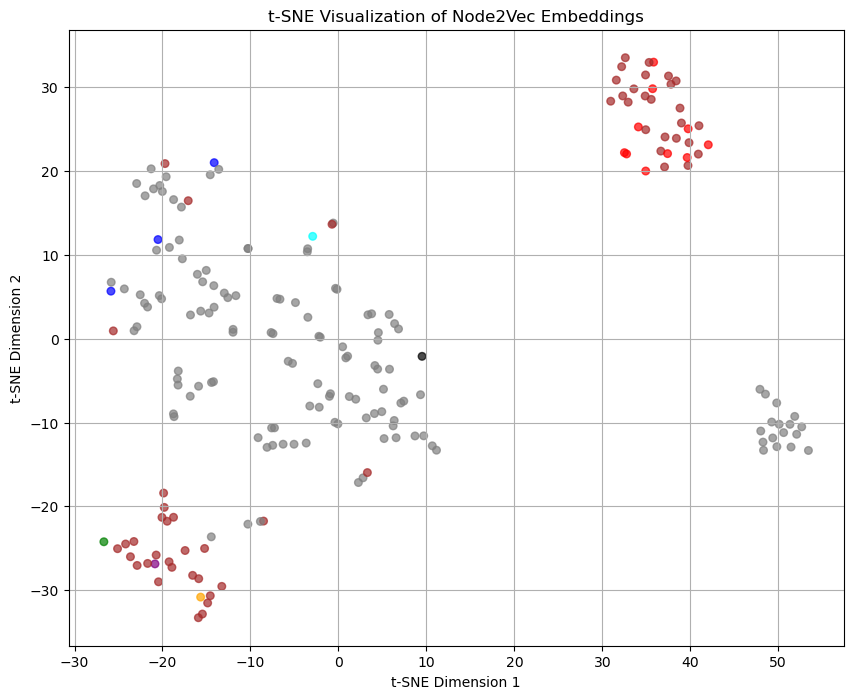

 Visualization complete.


In [11]:

# Step 4: Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=30, alpha=0.7)



plt.title("t-SNE Visualization of Node2Vec Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

print(" Visualization complete.")


Plot saved as 'node2vec_tsne_visualization.png'.


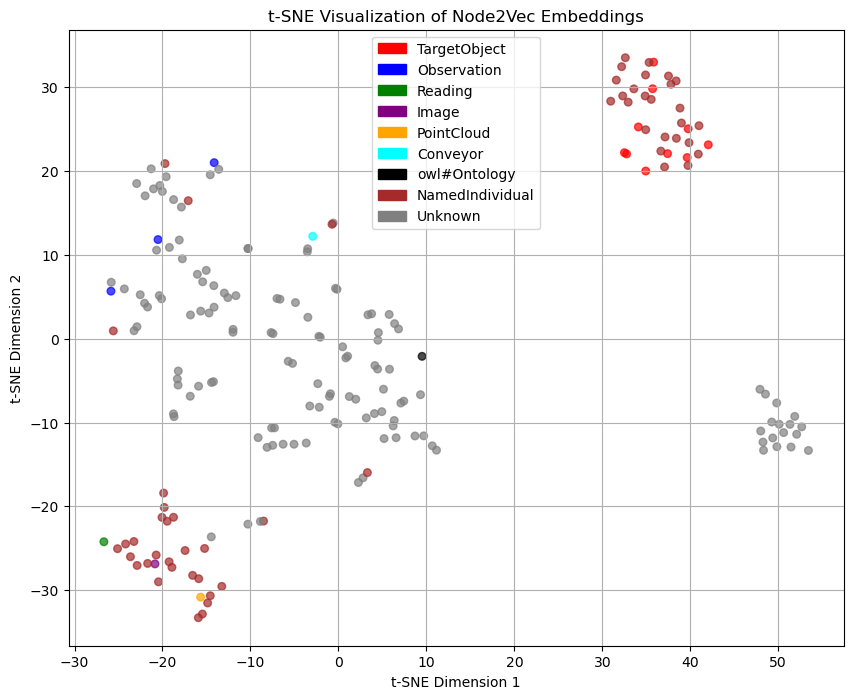

In [12]:
#scatter plot with assigned colors
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=30, alpha=0.7)

# Add legend manually
legend_elements = [
    mpatches.Patch(color='red', label='TargetObject'),
    mpatches.Patch(color='blue', label='Observation'),
    mpatches.Patch(color='green', label='Reading'),
    mpatches.Patch(color='purple', label='Image'),
    mpatches.Patch(color='orange', label='PointCloud'),
    mpatches.Patch(color='cyan', label='Conveyor'),
    mpatches.Patch(color='black', label='owl#Ontology'),
    mpatches.Patch(color='brown', label='NamedIndividual'),
    mpatches.Patch(color='gray', label='Unknown'),
]

plt.legend(handles=legend_elements, loc='best')
plt.title("t-SNE Visualization of Node2Vec Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Save the plot before showing it
plt.savefig("node2vec_tsne_visualization.png", dpi=300)
print("Plot saved as 'node2vec_tsne_visualization.png'.")

plt.show()


In [13]:
print(f"Node types extracted: {len(node_types)}")
print(f"Types found: {set(node_types.values())}")


Node types extracted: 80
Types found: {'Metadata', 'Conveyor', 'PhysicalAppearance', 'Reading', 'owl#NamedIndividual', 'Observation', 'TargetObject', 'PointCloud', 'MeasurementSample', 'Image', 'Comnponent', 'owl#Ontology'}


##  Insights from Node2Vec + t-SNE Visualization

### General Observations:
- The visualization successfully projects the RDF graph into 2D space using node2vec embeddings and t-SNE dimensionality reduction.
- Each point represents a node (e.g., a bin, observation, reading) from the RDF graph.
- Nodes have been **colored by their detected RDF type**, improving interpretability.

### Cluster Patterns:
- **Red cluster ("TargetObject")** stands out clearly on the right side of the plot, indicating a distinct structural role in the graph.
- **Orange, purple, and brown nodes** (e.g., PointCloud, Image, NamedIndividual) form visible groupings, suggesting internal semantic similarity.
- Many nodes remain **gray ("Unknown")**, which means they currently lack an explicit RDF type in the sample data — this will improve once we enrich the graph with taxonomy data.

### Interpretation:
- Node2Vec has captured meaningful relationships from the RDF structure:
  - Nodes sharing semantic or structural roles tend to cluster together.
  - The fact that types form visible clusters validates the effectiveness of the embedding approach.
- Visual patterns align well with expected categories, supporting further quantitative analysis.

### Next Steps:
- **Enrich the RDF graph** with additional semantic layers from `taxonomy.ttl` to reduce "Unknown" nodes and improve clustering.
- **Compute node similarities** to quantify relationships between nodes and support potential use cases like similarity search or recommendations.
- **Optional:** Perform clustering (e.g., K-Means) to validate and describe the observed visual groupings.
- **Document methodology**: Use these findings to explain the approach and insights in the thesis.

---

